In [67]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import h5py

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras import applications, layers

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.resnet50 import decode_predictions

In [69]:
train_dir = os.path.join("train")
val_dir = os.path.join("val")
test_dir = os.path.join("test")

These models attempt to predict whether an image contains a real bear or a teddy bear. The classes were chosen due to their inclusion in the ImageNet dataset meaning the ResNet50 base has been trained on them. They are also somewhat similar without being too hard to differentiate between.

Data augmentatation is clearly very important for a dataset of this very small size. For this reason I use the data generators below, with data augmentation on the train generator, for all my models. The zoom range has been set to 0.1 to ensure that key features, such as the face of a bear that lies on the edge of a picture, are not augmented out.

For all of the networks, I use the same values for steps_per_epoch, validation_steps, and epochs. The steps_per_epoch and validation_steps values (5) were chosen to cover the entire dataset on each epoch (data generator batch_size * steps_per_epoch). Number of epochs was chosen to ensure relative accuracy but also so training does not take an unreasonable amount of time (20 when base is frozen, 30 when base is unfrozen).

All models are also using the ResNet50 base and the same augmented data generators defined below. This consistency makes it easier to improve upon and compare the models.

In [70]:
augmented_train_data_generator_for_resnet = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

augmented_train_generator_for_resnet = augmented_train_data_generator_for_resnet.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=20, class_mode="binary")

val_data_generator_for_resnet = ImageDataGenerator(rescale=1./255)
val_generator_for_resnet = val_data_generator_for_resnet.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=10, class_mode="binary")

test_data_generator_for_resnet = ImageDataGenerator(rescale=1./255)
test_generator_for_resnet = test_data_generator_for_resnet.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=10, class_mode="binary")

Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# Network 1

First I tested the basic model below. From what I saw the model began to overfit quite early at around 0.69 training loss, even after fine tuning. I don't include this model due to running times.

In [5]:
#def build_network_with_transfer_learning_2():
#    network = Sequential()
#    network.add(resnet50_base)
#    resnet50_base.trainable = False
#    network.add(Flatten())
#    network.add(Dense(256, activation="relu"))
#    network.add(Dense(1, activation="sigmoid"))
#    network.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["accuracy"])
#    return network

To improve on this I added the following:

-Convolution layer of shape 64, (3, 3) to refine the relevant features, and reduce overfitting along with a

-Max pooling layer of (2, 2) to further reduce params and reduce overfitting. 

-Exponential decay, allowing the model to get closer to the min loss faster and then adjust in smaller increments providing a more accurate model within the epoch constraint. 

Each of these new additions was tested individually and proved to be effective, so I combine them into one network here.

In testing this model, I also included a dropout layer, with the idea that it would prevent overfitting to this small dataset by further reducing parameters. Unfortunately it decreased the accuracy of the model. Different types of dense layers (eg. 128, 64) were also tried to no great effect.

Due to issues I was having with fine tuning the network whereby training loss would skyrocket after just one iteration, I found this PR - https://github.com/keras-team/keras/pull/9965 which seemed to describe my issue. This solution, involving overriding the layers module used when build the base model to allow for the use of a custom version of batch normalization, worked for me - https://github.com/keras-team/keras/pull/9965#issuecomment-501933060 . I include it below.

In [6]:
class FrozenBatchNormalization(layers.BatchNormalization):
    def call(self, inputs, training=None):
        return super().call(inputs=inputs, training=False)

# Keep a copy of the original class
BatchNormalization = layers.BatchNormalization

# Patch the class temporarily
layers.BatchNormalization = FrozenBatchNormalization

# Build the model with our patched version of layers
resnet50_base = ResNet50(weights="imagenet", layers=layers, include_top=False, input_shape=(224, 224, 3))

# Undo the patch
layers.BatchNormalization = BatchNormalization

resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (FrozenBatchNormalizat (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

First, I used the learning rate finder from lectures to get an idea of the approx best lr. From this I saw around 0.0001 (x10 times smaller than just before the loss begins to rise). Obviously when using exponential decay, the initial rate can be a bit higher than this. The learning rate finder is commented out below to reduce running time.

In [7]:
#lr_finder = LearningRateFinder(transfer_learning_network)

#lr_finder.find(trainData=augmented_train_generator_for_resnet, 
               #startLR=1e-8, endLR=1e-1, stepsPerEpoch=5,
               #epochs=15, batchSize=32, verbose=0)

#lr_finder.plot_loss(skipBegin=10, skipEnd=1, title="")

The learning rate schedule below has been chosen to get as close to the overfitting point as possible without breaching it. In my testing, an inital rate of 2e-3 and a decay of 0.9 proved most effective.

In [8]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

In [9]:
def build_network_with_transfer_learning():
    network = Sequential()
    network.add(resnet50_base)
    resnet50_base.trainable = False
    network.add(Conv2D(32,(3,3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(256, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["accuracy"])
    return network

In [10]:
transfer_learning_network = build_network_with_transfer_learning()
transfer_learning_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          589856    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,210,849
Trainable params: 623,137
Non-trainable params: 23,587,712
______________________________________

In [11]:
transfer_learning_history = transfer_learning_network.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=5, epochs=20,
                validation_data=val_generator_for_resnet, validation_steps=5,
                verbose=0, callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

(0.0, 1.0)

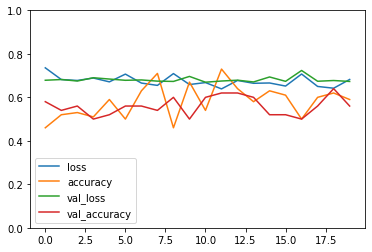

In [12]:
net2 = pd.DataFrame(transfer_learning_history.history).plot()
net2.set_ylim(0, 1)

### Unfreeze the base
Here I also tried unfreezing just the top parts of the base, while leaving the lower layers frozen. This unfortunately did not improve the model so I include it commented out below.

In [13]:
#for layer in resnet50_base.layers[:60]:
#   layer.trainable = False
#for layer in resnet50_base.layers[60:]:
#   layer.trainable = True

In [14]:
resnet50_base.trainable = True

I will also use exponential decay after unfreezing the base, with a much lower initial learning rate. I found 2e-4 with a decay of 0.9 to be the most effective.

In [15]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

In [16]:
transfer_learning_network.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
tuned_history = transfer_learning_network.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=5, epochs=30,
                validation_data=val_generator_for_resnet, validation_steps=5,
                verbose=0, callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

(0.0, 1.0)

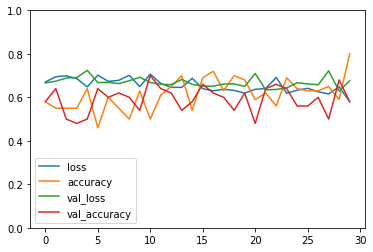

In [18]:
graph = pd.DataFrame(tuned_history.history).plot()
graph.set_ylim(0, 1)

# Network 2
Here I try another optimizer, Adam. Adam is an adaptive learning rate method, which means it computes individual learning rates for different parameters. I saw a significant improvement using Adam over the standard SGD, allowing me to reduce the loss even further without overfitting. The improvement in accuracy is massive, ~20% better.

In [71]:
# Patch the class temporarily
layers.BatchNormalization = FrozenBatchNormalization

# Build the model with our patched version of layers
resnet50_base = ResNet50(weights="imagenet", layers=layers, include_top=False, input_shape=(224, 224, 3))

# Undo the patch
layers.BatchNormalization = BatchNormalization

After trying the learning rate finder again and some trial and error, I found 2e-3 to be the best learning rate.

In [72]:
def build_network_with_transfer_learning_2():
    network = Sequential()
    network.add(resnet50_base)
    resnet50_base.trainable = False
    network.add(Conv2D(32,(3,3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(256, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=Adam(learning_rate=2e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return network

In [73]:
transfer_learning_network_2 = build_network_with_transfer_learning_2()
transfer_learning_network_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          589856    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 24,210,849
Trainable params: 623,137
Non-trainable params: 23,587,712
____________________________________

In [74]:
transfer_learning_history_2 = transfer_learning_network_2.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=5, epochs=20,
                validation_data=val_generator_for_resnet, validation_steps=5,
                verbose=0, callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

(0.0, 1.0)

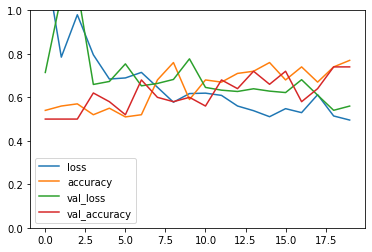

In [75]:
net2 = pd.DataFrame(transfer_learning_history_2.history).plot()
net2.set_ylim(0, 1)

### Unfreeze the base

Here, I found the learning rate of 5e-7 to be best.

In [76]:
resnet50_base.trainable = True

In [77]:
transfer_learning_network_2.compile(optimizer=Adam(learning_rate=5e-7), loss="binary_crossentropy", metrics=["accuracy"])

In [78]:
tuned_history_2 = transfer_learning_network_2.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=5, epochs=30,
                validation_data=val_generator_for_resnet, validation_steps=5,
                verbose=0, callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

(0.0, 1.0)

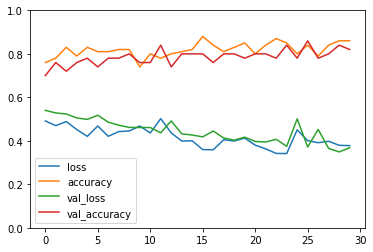

In [79]:
net2 = pd.DataFrame(tuned_history_2.history).plot()
net2.set_ylim(0, 1)

# Evaluate on the test set

In [80]:
test_loss, test_acc = transfer_learning_network.evaluate(test_generator_for_resnet)
test_acc

test_loss, test_acc = transfer_learning_network_2.evaluate(test_generator_for_resnet)
test_acc

5/5 [==============================] - 3s 536ms/step - loss: 0.3294 - accuracy: 0.8200


0.8199999928474426

In [81]:
transfer_learning_network_2.save("best_network")

INFO:tensorflow:Assets written to: best_network\assets
